# Project: Investigate a Dataset (Film earnings and reviews)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I've chosen to review the TMDb movie data.  This data set includes 10,000 movies collected from The Movie Databas (TMDb), including user ratings and reviews.  I've chosen this data set because I'm primarily interested in understanding the relationship between popularity (earnings) and quality (reviews).  I would like to consider each of these as dependent variables and gain insight into what might be associated with either popularity or quality in isolation first.  I would then like to consider how these two *measures of success* relate to each other.

Therefore the key questions I would like to investigate further are as follows:

> 1. What features are associated with higher or lower overall adjusted earnings?
> 2. What features are associated with higher or lower overall ratings?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


<a id='wrangling'></a>
## Data Wrangling

My initial step before understanding the qualities and nature of each attribute was simply an quick overview and consideration of relevant fields needed to answer my key questions.  A deeper assesment of the data and cleaning will take place at a later point.

### General Properties

Initially I pulled in the raw data set using pandas read_csv functionality and subsequently pulled the first five records to get a feel for the format, type and complexity of the various attributes.  While there appear to be various options for alternate indexing including either *id* or *imdb_id* I do not believe both of these will be necessary for the analysis and would like to remove both indexes along with *original_title*, *homepage*, *tagline*, *keywords* and*overview* as these fields seem more relevant to advanced NLP analysis.  I also elected to focus only on adjusted revenue and budget to make sure comparability across time is valid thus we have also decied to drop *budget* and *revenue*

Its clear that while *cast*, *genres* and *production_companies* need some consideration on how to split out, thus leaving them as a range of possible groupby attributes to understand a deeper level of the data.  This will require some addtional thinking and work to address later on.

In [2]:
df = pd.read_csv('tmdb-movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [3]:
df.drop(['id','imdb_id','original_title','homepage','tagline','overview','keywords','budget','revenue'], axis = 1, inplace = True)
df.head(1)

,popularity,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


### Data Cleaning

Here I would like to explore more holistically the data set, with the extra fields removed.  Focus will be on making sure fields are consistent, in the proper format (float, string, integer), removing duplicates and addressing any null values for each field.  Equally we will want to do a basic visual exploration of the data to get a feel for distributions and any material skewness or significant outliers that need consideration at this stage.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 12 columns):
popularity              10866 non-null float64
cast                    10790 non-null object
director                10822 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              10866 non-null float64
revenue_adj             10866 non-null float64
dtypes: float64(4), int64(3), object(5)
memory usage: 1018.8+ KB


#### Datatypes

Datatype changes needed as follows:
    
    1. release_date changed to a date from string
    2. budget_adj converted to a £1,000,000 multiple so its easier to work with
    3. revenue_adj converted to a £1,000,000 multiple so its easier to work with
    4. columns renamed to indicate these are multiples of £1,000,000 using the standard 'Ms' convention and removed the adjusted flag as there is no base budget or revenue anymore.


In [5]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['revenue_adj'] = (df['revenue_adj']/1000000).round(0)
df['budget_adj'] = (df['budget_adj']/1000000).round(0)
df.rename(columns = {'budget_adj':'budget_Ms','revenue_adj':'revenue_Ms'}, inplace = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 12 columns):
popularity              10866 non-null float64
cast                    10790 non-null object
director                10822 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null datetime64[ns]
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_Ms               10866 non-null float64
revenue_Ms              10866 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 1018.8+ KB


#### Calculations

We equally would want to add an adjusted profit figure and an adjusted return figure.  Profit would simply be the *adj_revenue* less the *adj_cost* and a return measure would be the profit divided by the *adj_budget* multiplied by 100 to get a % return.

In doing this I discovered that there are quite a few films with a budget and revenue of 0, while its important to note this for one of my key questions around attributes impacting revenue, its less relevant for the discussion around popluarity/ratings.  As such rather than drop these rows I have simply made sure that the N/As are replaced with 0 for things like return and/or profit.  Equally have a budge of 0 did not necessarily mean there was a profit or in theory return of 0 because they might have still generated revenue.  In this case I then discovered this generated an infinite max which I needed to fileter down on and replace with some arbitrary value.  In this case I decided that you cannot have a return if you did not investe (i.e. spend money on the film) so I default to a return of 0 in cases where the film made a profit without any expenditure.

In [6]:
df.head(1)

,popularity,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_Ms,revenue_Ms
0,32.985763,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,138.0,1392.0


In [7]:
df['profit'] = df['revenue_Ms']-df['budget_Ms']
df['return_%'] = (((df['profit']/df['budget_Ms'])*100).round(2))
df['return_%'].fillna(0,inplace = True)
df['return_%'].replace(df['return_%'].max(),0,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 14 columns):
popularity              10866 non-null float64
cast                    10790 non-null object
director                10822 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null datetime64[ns]
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_Ms               10866 non-null float64
revenue_Ms              10866 non-null float64
profit                  10866 non-null float64
return_%                10866 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3), object(4)
memory usage: 1.2+ MB


In [8]:
# Just checking here that this now actually shows a proper maximum value as opposed to inifinite.

df_inf = df[df['return_%']==df['return_%'].max()]
df_inf

,popularity,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_Ms,revenue_Ms,profit,return_%
7827,2.012021,Mel Gibson|Joanne Samuel|Hugh Keays-Byrne|Stev...,George Miller,93,Adventure|Action|Thriller|Science Fiction,Kennedy Miller Productions|Mad Max Films|Cross...,1979-04-12,667,6.5,1979,1.0,300.0,299.0,29900.0


In [9]:
df.head()

,popularity,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_Ms,revenue_Ms,profit,return_%
0,32.985763,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,138.0,1392.0,1254.0,908.70
1,28.419936,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,138.0,348.0,210.0,152.17
2,13.112507,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2480,6.3,2015,101.0,272.0,171.0,169.31
3,11.173104,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,5292,7.5,2015,184.0,1903.0,1719.0,934.24
4,9.335014,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2015-04-01,2947,7.3,2015,175.0,1386.0,1211.0,692.00


#### Null values & Duplicates

Currently it looks like the only fields with null values are strings.  Currently I do not feel it would be appropriate to try and fill these as they are non numerical and instead would represent key categories by which to group the data.  As such I have choosen to simply drop all null value records.

Equally here I've looked identified and dropped any duplicated records as each film should only appear once, noting even mislabeled sequels would have different features such as cost, revenue, release date etc...

In [10]:
df.dropna(inplace = True)
df.shape

(9773, 14)

In [11]:
df.drop_duplicates(inplace = True)
df.shape

(9772, 14)

#### Skewness, distribution and outliers

I've done a very basic initial histogram exploration to understand how the different numerical data points are represented across the new reduced data set.  There remains a significant data field issue to address regarding the fields *cast*, *keywords*, *genres*, *production_companies* which will be addressed using the same approach as a final step in the cleaning process.  While this was done to just check if any additional cleaning is needed, I did note things that popped immediately to me.

> Interesting observations on the distribution as follows:

> 1. Overall budgets are very skewed to the right but equally so is popularity, which might initially suggest that generally there is a small number of films that have very wide reach and appeal with the bulk of filmaking taking place at the lower end of the budget spectrum with a generally more limited audience.

> 2. Release years is skewed to the left suggesting a marked increase in film releases over time, this seems reasonable but equally this doesn't seem to align with any of the other measures such as budget, popularity or revenue suggesting that although volume overall has increased, high earning, expensive or popular films still remain the exception rather than the rule.

> 3. Run time seems to be a pretty tight normal distribution suggesting over time films have remains the same length, so this might be something less interesting to explore

> 4. Average vote score looks to be nicely distirbuted round roughly 6 with an even tail on either end (normal distirbution).  This gives me confidence that overall ratings are pretty much reliable as there is no overall biase towards generally low or generally high rartings.  Thus a 10 would be exceptional and a 1 would equally be dismall.

> 5. Most films look to have only a small number of votes as noted in the expanded votes graph with a tighter bin size.

> 6. There looks to be a few major outliers for return % so while its a nice to have it might be less useful than the simple discrete measure of profit, which allows for films with 0 budget

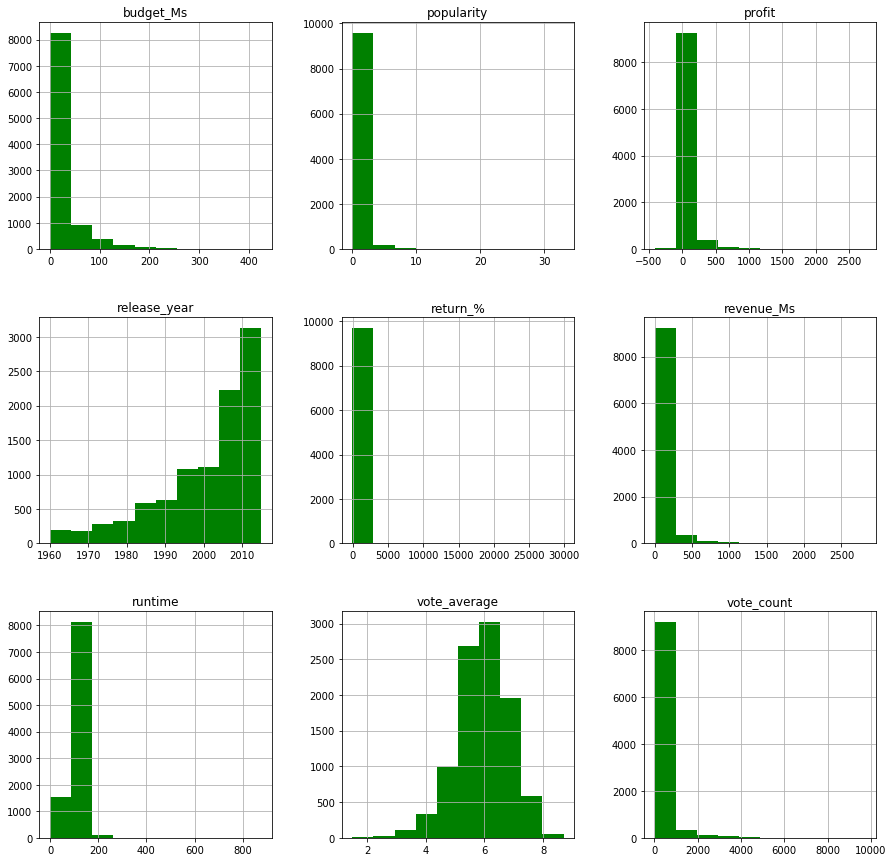

In [12]:
df.hist(figsize=(15,15), color = 'g');

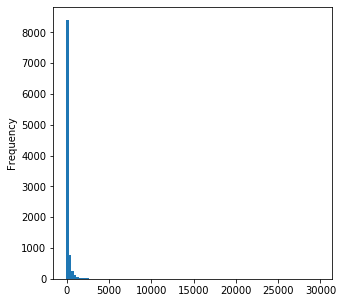

In [13]:
df['return_%'].plot(kind='hist',bins = 100, figsize=(5,5));

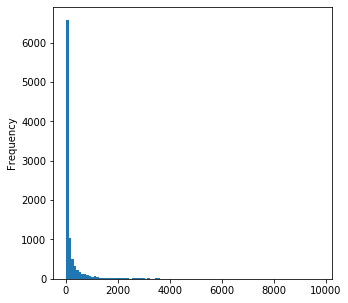

In [14]:
df['vote_count'].plot(kind='hist',bins = 100, figsize =(5,5));

#### Splitting Combined Columns

Here we need to address the issue of the data in the following columns; *cast*, *genre* and *production_companies*.  I decided to split these columns out horizontally as new columns as this would allow much simpler groupbys per column without needed to filter down to unique records.  While I think there are arguments for both approaches splitting into rows would result in a complicated permutation of which actor gets which genre and which production company for each film....essentially requiring a significant number of new rows to make sure we get each possible combination.  Splitting by column allows us to simply pick the 1st, 2nd or 3rd entry for each field assuming the first is the lead actor, genre or production company for simplicity.

In order to accomplish this I used a for loop and the string split function to essentially create a new dataframe with the columns split and then to run through each index and create counted new column name for each iteration.  This allowed me to simply copy and paste the code for each of the attributes

In [15]:
df.head(1)

,popularity,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_Ms,revenue_Ms,profit,return_%
0,32.985763,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,138.0,1392.0,1254.0,908.7


In [16]:
cast = df['cast'].str.split("|", n=-1, expand = True)

for index in cast.columns:
    df['cast_{}'.format(index+1)]=cast[index]

df.drop(['cast'], axis = 1, inplace = True)

In [17]:
df.head(1)

,popularity,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_Ms,revenue_Ms,profit,return_%,cast_1,cast_2,cast_3,cast_4,cast_5
0,32.985763,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,138.0,1392.0,1254.0,908.7,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,Vincent D'Onofrio,Nick Robinson


In [18]:
df.shape

(9772, 18)

In [19]:
genres = df['genres'].str.split("|", n=-1, expand = True)

for index in genres.columns:
    df['genres_{}'.format(index+1)]=genres[index]

df.drop(['genres'], axis = 1, inplace = True)

In [20]:
df.head(1)

,popularity,director,runtime,production_companies,release_date,vote_count,vote_average,release_year,budget_Ms,revenue_Ms,...,cast_1,cast_2,cast_3,cast_4,cast_5,genres_1,genres_2,genres_3,genres_4,genres_5
0,32.985763,Colin Trevorrow,124,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,138.0,1392.0,...,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,Vincent D'Onofrio,Nick Robinson,Action,Adventure,Science Fiction,Thriller,None


In [21]:
df.shape

(9772, 22)

In [22]:
production_companies = df['production_companies'].str.split("|", n=-1, expand = True)

for index in production_companies.columns:
    df['prod_co_{}'.format(index+1)]=production_companies[index]

df.drop(['production_companies'], axis = 1, inplace = True)

In [23]:
df.head(1)

,popularity,director,runtime,release_date,vote_count,vote_average,release_year,budget_Ms,revenue_Ms,profit,...,genres_1,genres_2,genres_3,genres_4,genres_5,prod_co_1,prod_co_2,prod_co_3,prod_co_4,prod_co_5
0,32.985763,Colin Trevorrow,124,2015-06-09,5562,6.5,2015,138.0,1392.0,1254.0,...,Action,Adventure,Science Fiction,Thriller,None,Universal Studios,Amblin Entertainment,Legendary Pictures,Fuji Television Network,Dentsu


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 0 to 10865
Data columns (total 26 columns):
popularity      9772 non-null float64
director        9772 non-null object
runtime         9772 non-null int64
release_date    9772 non-null datetime64[ns]
vote_count      9772 non-null int64
vote_average    9772 non-null float64
release_year    9772 non-null int64
budget_Ms       9772 non-null float64
revenue_Ms      9772 non-null float64
profit          9772 non-null float64
return_%        9772 non-null float64
cast_1          9772 non-null object
cast_2          9688 non-null object
cast_3          9635 non-null object
cast_4          9566 non-null object
cast_5          9359 non-null object
genres_1        9772 non-null object
genres_2        7813 non-null object
genres_3        4710 non-null object
genres_4        1848 non-null object
genres_5        507 non-null object
prod_co_1       9772 non-null object
prod_co_2       6385 non-null object
prod_co_3       3812 non-null o

#### Thoughts on Further Analysis

At this point we now have a large number of columns noting 5 cast members, 5 genres and 5 production companies.  However not every film has multple records for each of these fields. In fact only the cast members seem to have limited deterioration as you go further through the breakout noting that 9359 films had a full 5 cast members listed.  However only 507 films had 5 genres listed and only 1124 films had 5 production companies listed.  This has led me to believe that in fact we are better off keeping only the first *genre* and the first *production company* simply to make the dataset a bit more manageable for the purposes of this analysis.  Thus the final step in the cleaning process was to now drop 8 of the new columns we just created.  

In [25]:
df.drop(['genres_2','genres_3','genres_4','genres_5','prod_co_2','prod_co_3','prod_co_4','prod_co_5'], axis = 1, inplace = True)
df.head(1)

,popularity,director,runtime,release_date,vote_count,vote_average,release_year,budget_Ms,revenue_Ms,profit,return_%,cast_1,cast_2,cast_3,cast_4,cast_5,genres_1,prod_co_1
0,32.985763,Colin Trevorrow,124,2015-06-09,5562,6.5,2015,138.0,1392.0,1254.0,908.7,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,Vincent D'Onofrio,Nick Robinson,Action,Universal Studios


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 0 to 10865
Data columns (total 18 columns):
popularity      9772 non-null float64
director        9772 non-null object
runtime         9772 non-null int64
release_date    9772 non-null datetime64[ns]
vote_count      9772 non-null int64
vote_average    9772 non-null float64
release_year    9772 non-null int64
budget_Ms       9772 non-null float64
revenue_Ms      9772 non-null float64
profit          9772 non-null float64
return_%        9772 non-null float64
cast_1          9772 non-null object
cast_2          9688 non-null object
cast_3          9635 non-null object
cast_4          9566 non-null object
cast_5          9359 non-null object
genres_1        9772 non-null object
prod_co_1       9772 non-null object
dtypes: datetime64[ns](1), float64(6), int64(3), object(8)
memory usage: 1.4+ MB


<a id='eda'></a>
## Exploratory Data Analysis

A noted previously I am going to address 3 main questions as opposed to two to sequentially work through the key relationships across the various attributes.

In [39]:
df.describe()

,popularity,runtime,vote_count,vote_average,release_year,budget_Ms,revenue_Ms,profit,return_%
count,9772.000000,9772.000000,9772.000000,9772.000000,9772.000000,9772.000000,9772.000000,9772.000000,9772.000000
mean,0.694721,102.926627,239.312014,5.963528,2000.878428,19.410356,57.048915,37.638559,112.791493
std,1.036931,27.877432,603.011504,0.913174,13.036794,35.662418,151.453675,131.481586,674.344922
min,0.000188,0.000000,10.000000,1.500000,1960.000000,0.000000,0.000000,-414.000000,-100.000000
25%,0.232710,90.000000,18.000000,5.400000,1994.000000,0.000000,0.000000,0.000000,0.000000
50%,0.419762,100.000000,46.000000,6.000000,2005.000000,0.000000,0.000000,0.000000,0.000000
75%,0.776408,112.000000,173.000000,6.600000,2011.000000,25.000000,43.000000,20.000000,29.185000
max,32.985763,877.000000,9767.000000,8.700000,2015.000000,425.000000,2827.000000,2750.000000,29900.000000


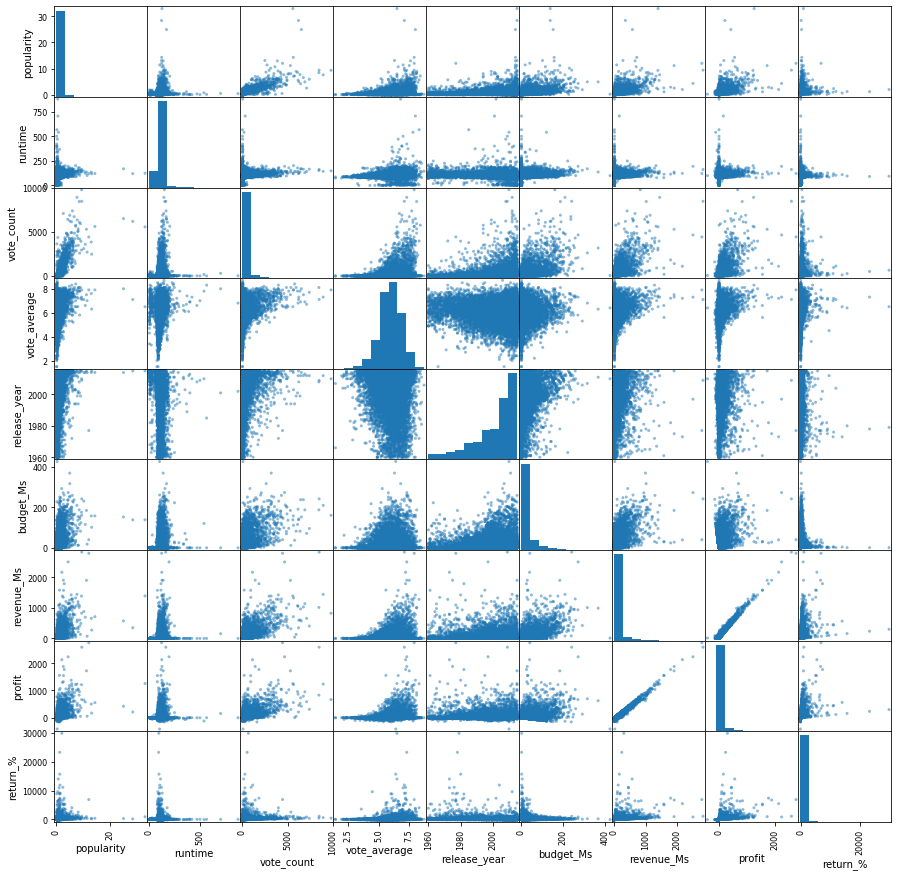

In [40]:
# Initial scatter matrix for quick assessment of attributes to look into.

pd.plotting.scatter_matrix(df, figsize = (15,15));

### Research Question 1 (What features are associated with overall higher or lower adjusted revenue)

An initial scatter matrix was used to quickly look at the various relationships with *revenue_Ms* (which is the renamed revenue_adj).  Working vertically up from *return_%* we can identify the following numerical attributes as worth investigating

> 1. *budget_Ms* looks to have a positive correlation with our dependent variable.
> 2. *vote_average* looks to have a mildly positive correlation with our dependent variable.
> 3. *vote_count* looks to have a positive correlation with our dependent variable.
> 4. *popularity* looks to have a positive a mildly positive correlation with our dependent variable

Based on these facts I wanted to then expand 2 of these relationships that I found the most interesting, namely *budget_Ms* and *popularity*

I'll provide a brief summary of the analysis after looking at each before moving on to question 2

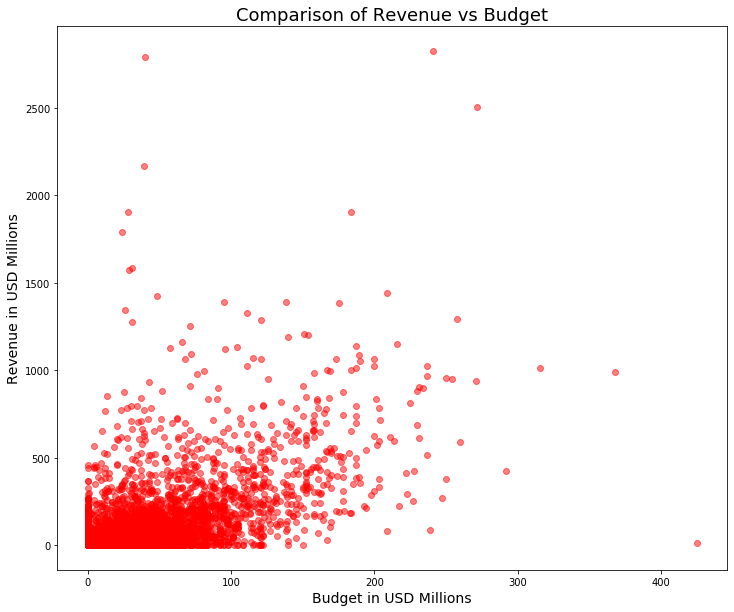

In [29]:
# Basic scatter plot of budget vs revenue swithing the X and Y axis so the dependent variable (revenue) is on the Y axis

plt.figure(figsize=(12,10))
plt.scatter(df['budget_Ms'],df['revenue_Ms'], color='r', alpha = .5)

plt.title('Comparison of Revenue vs Budget', fontsize = 18)
plt.xlabel('Budget in USD Millions', fontsize = 14)
plt.ylabel('Revenue in USD Millions', fontsize = 14);


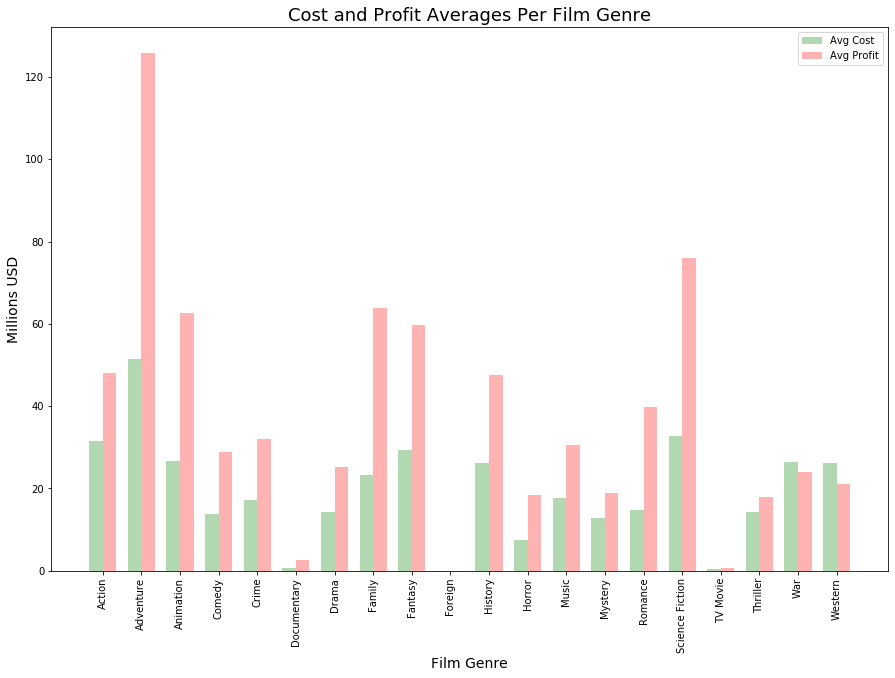

In [30]:
# Bar chart of average return per Genre along with average budget per Genre

# create the new values per genre

average_cost = df.groupby('genres_1').mean()['budget_Ms']
average_profit = df.groupby('genres_1').mean()['profit']

#create a standar index, width and graph size

ind = np.arange(len(average_cost))
width = 0.35
plt.figure(figsize=(15,10))

#create the base bar graphs

cost_bar = plt.bar(ind, average_cost, width, color = 'g', alpha = .3, label = 'Avg Cost')
revenue_bar = plt.bar(ind + width, average_profit, width, color = 'r', alpha =.3, label ='Avg Profit')

#add, format and size the various labels

plt.ylabel('Millions USD', fontsize = 14)
plt.xlabel('Film Genre', fontsize = 14)
plt.title('Cost and Profit Averages Per Film Genre', fontsize = 18)
locations = ind+width/2
labels = average_cost.index
plt.xticks(locations,labels, rotation = 90)

plt.legend();

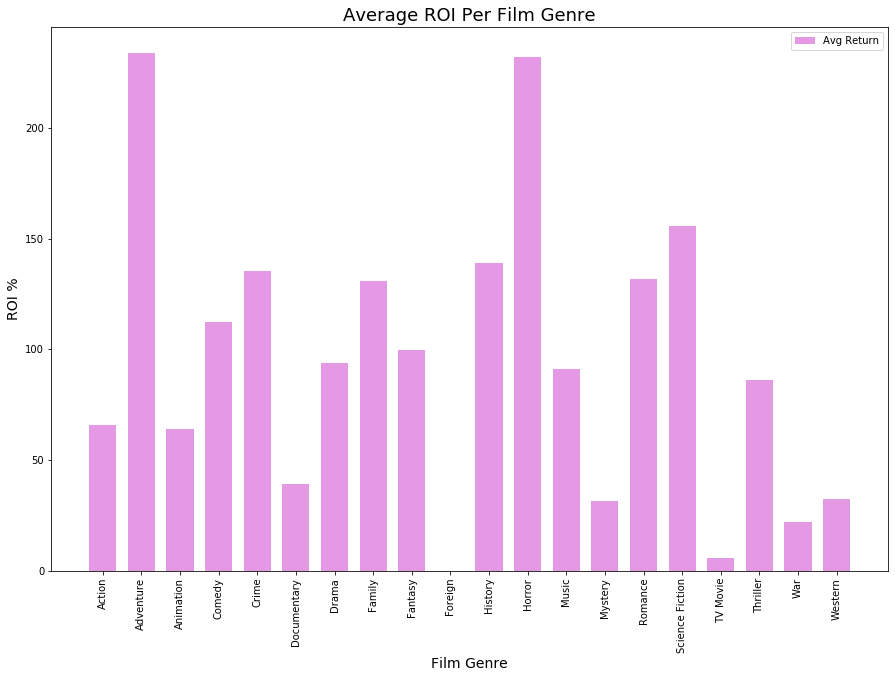

In [31]:
# Bar chart of average return per Genre 

# create the new values per genre

average_return = df.groupby('genres_1').mean()['return_%']

#create a standar index, width and graph size

ind = np.arange(len(average_return))
width = 0.70
plt.figure(figsize=(15,10))

#create the base bar graphs

return_bar = plt.bar(ind, average_return, width, color = 'm', alpha = .4, label = 'Avg Return')

#add, format and size the various labels

plt.ylabel('ROI %', fontsize = 14)
plt.xlabel('Film Genre', fontsize = 14)
plt.title('Average ROI Per Film Genre', fontsize = 18)
labels = average_return.index
plt.xticks(ind,labels, rotation = 90)

plt.legend();

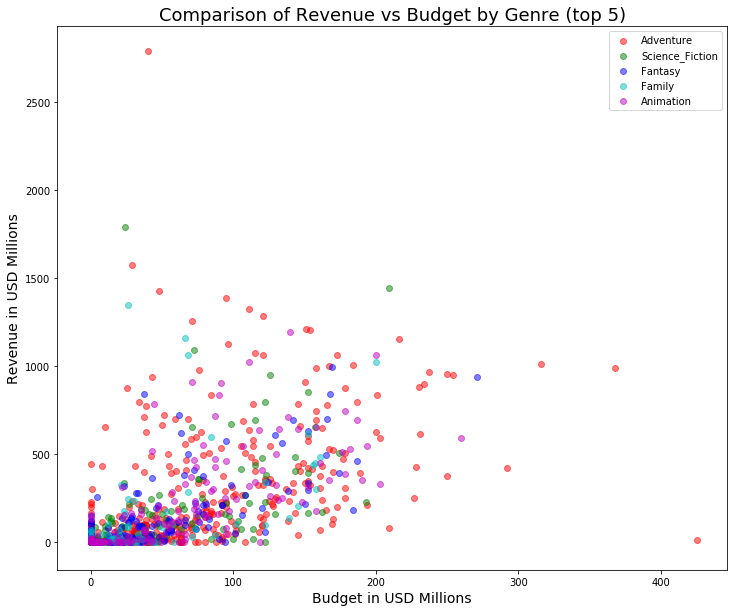

In [32]:
# Scatter plot of budget vs revenue grouped by Genre only showing top five genres for now

# create new dfs for each of the main genres, I was going to use a for loop but 
# since I only wanted these five I just did it manually

Adventure = df[df['genres_1'] == 'Adventure']
Science_Fiction = df[df['genres_1'] == 'Science Fiction']
Fantasy = df[df['genres_1'] == 'Fantasy']
Family = df[df['genres_1']=='Family']
Animation = df[df['genres_1']=='Animation']

# plot each with a differnt color on the same scatterplot

plt.figure(figsize=(12,10))
plt.scatter(Adventure['budget_Ms'],Adventure['revenue_Ms'], color='r', alpha = .5, label = 'Adventure')
plt.scatter(Science_Fiction['budget_Ms'],Science_Fiction['revenue_Ms'], color='g', alpha = .5, label = 'Science_Fiction')
plt.scatter(Fantasy['budget_Ms'],Fantasy['revenue_Ms'], color='b', alpha = .5, label='Fantasy')
plt.scatter(Family['budget_Ms'],Family['revenue_Ms'], color='c', alpha = .5, label = 'Family')
plt.scatter(Animation['budget_Ms'],Animation['revenue_Ms'], color='m', alpha = .5, label = 'Animation')

plt.title("Comparison of Revenue vs Budget by Genre (top 5)", fontsize = 18)
plt.xlabel('Budget in USD Millions', fontsize = 14)
plt.ylabel('Revenue in USD Millions', fontsize = 14)

plt.legend();

    

##### Budget Analysis Summary

Initial thoughts are that in general bigger budget films tend to generate more revenue.  This can be evidenced in a few ways, HOWEVER id does not mean that spending more results in more revenue...correlation does NOT equal causation.

1. The initial scatter plot shows a clear, if not broad positive correlation between cost (budget) and earnings (revenue).  Obviously this can be tricky since budget likely includes lots of aspects of film production including things like marketing and advertising, so this doesn't necessarily indicate that bigger budgets mean 'better' films, it just means they have more disposable funds in theory.

2. When looking at the bar chart of cost vs profit in most cases spending more on average looks to result in higher profits (revenue after costs).  However this isn't always the case noting specifically something like 'Animation' or 'Family'.  These two Genres had relatively high profits but lowers costs than comparable cost genres like History, War, Action and Western.  The latter two being the least profitable genres. This actually makes logical sense as Family and Animation have the addressable viewer base with a very wide 'target age range', whereas war films could be very polarising and have more restrictive ratings.

3. The two most expensive Genres, based on average budget, were Action and Adventure.  However the two genres with the highest ROI were Adventure and Horror, noting both had a returns in excess of 200%.  This might suggest that on a deeper level, while broadly spending more means you get more revenue, it doesn't necessarily mean doing so is the smartest use of funds.

Based on this first bit of analysis if I were doing film production and I had a very large investment pot I would focus on family and adventure as they had the highest ROIs where bigger budgets were the norm.  If I had a smaller investment pot I would focus on Horror films where while the overall spend and revenue appear to be low the returns are extremely high.  **Thus while there is a relationship between budgets and revenue this relationship differs depending on the genre and equally revenue alone might not be the best measure of success.**

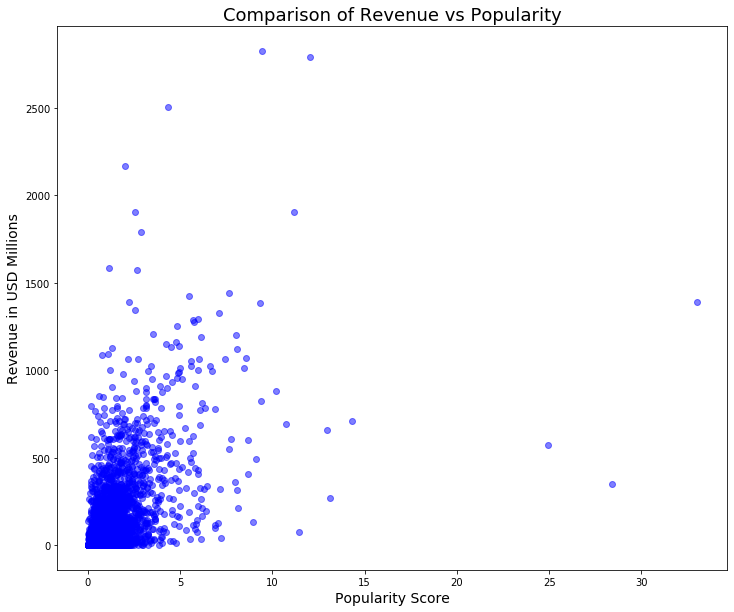

In [33]:
# Basic scatter plot of popularity vs revenue swithing the X and Y axis so the dependent variable (revenue) is on the Y axis

plt.figure(figsize=(12,10))
plt.scatter(df['popularity'],df['revenue_Ms'], color='b', alpha = .5)

plt.title('Comparison of Revenue vs Popularity', fontsize = 18)
plt.xlabel('Popularity Score', fontsize = 14)
plt.ylabel('Revenue in USD Millions', fontsize = 14);

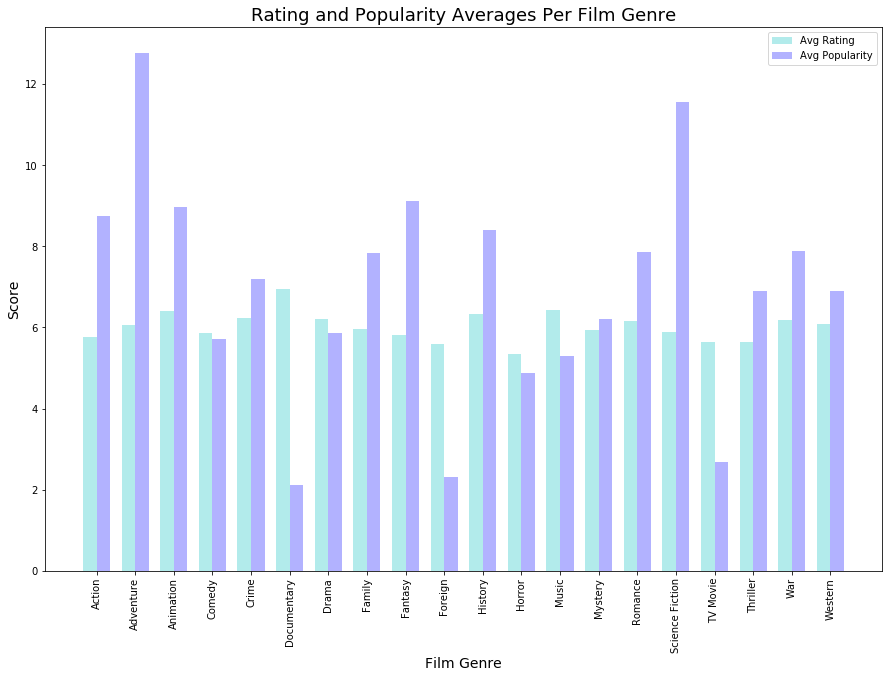

In [34]:
# Bar chart of popularity vs rating, to understand if these are sort of the same

# create the new values per genre. Note here I multiplies the average_popularity score by 10
# to standardise based on the information noted through the descriptive statistics.

average_rating = df.groupby('genres_1').mean()['vote_average']
average_popularity = df.groupby('genres_1').mean()['popularity']*10

#create a standar index, width and graph size

ind = np.arange(len(average_rating))
width = 0.35
plt.figure(figsize=(15,10))

#create the base bar graphs

rating_bar = plt.bar(ind, average_rating, width, color = 'c', alpha = .3, label = 'Avg Rating')
popularity_bar = plt.bar(ind + width, average_popularity, width, color = 'b', alpha =.3, label ='Avg Popularity')

#add, format and size the various labels

plt.ylabel('Score', fontsize = 14)
plt.xlabel('Film Genre', fontsize = 14)
plt.title('Rating and Popularity Averages Per Film Genre', fontsize = 18)
locations = ind+width/2
labels = average_cost.index
plt.xticks(locations,labels, rotation = 90)

plt.legend();

Popularity looks more volatile than ratings so it might be a better measure of overall 'quality'.  Its hard to say what the difference really is here so this would require further digging.  I guess popularity might not translate directly into quality as critics would argue the best films are generally not well understood or received by the public, but I prefer to think that a good film is one people like so popularity is the measure we will stick with for now.

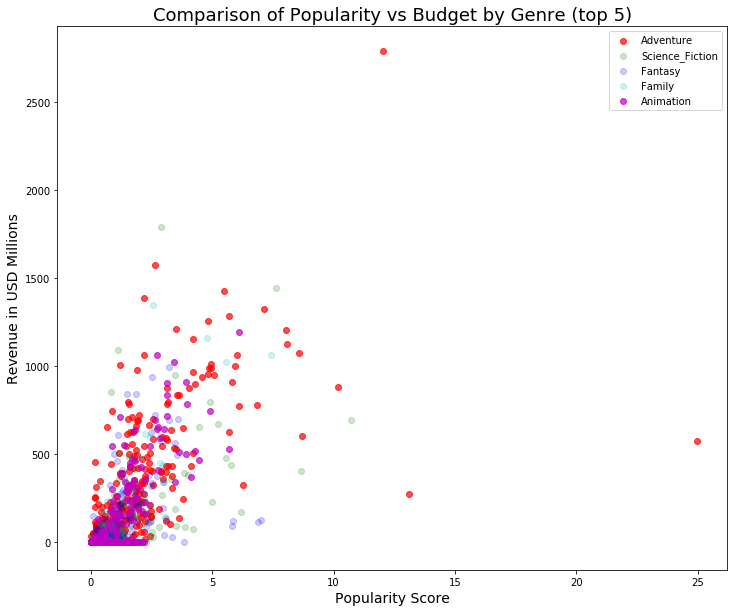

In [38]:
# Scatter plot of popularity vs revenue grouped by Genre only showing top five revenue genres for now

# plot each with a differnt color on the same scatterplot

plt.figure(figsize=(12,10))
plt.scatter(Adventure['popularity'],Adventure['revenue_Ms'], color='r', alpha = .7, label = 'Adventure')
plt.scatter(Science_Fiction['popularity'],Science_Fiction['revenue_Ms'], color='g', alpha = .2, label = 'Science_Fiction')
plt.scatter(Fantasy['popularity'],Fantasy['revenue_Ms'], color='b', alpha = .2, label='Fantasy')
plt.scatter(Family['popularity'],Family['revenue_Ms'], color='c', alpha = .2, label = 'Family')
plt.scatter(Animation['popularity'],Animation['revenue_Ms'], color='m', alpha = .7, label = 'Animation')

plt.title("Comparison of Popularity vs Budget by Genre (top 5)", fontsize = 18)
plt.xlabel('Popularity Score', fontsize = 14)
plt.ylabel('Revenue in USD Millions', fontsize = 14)

plt.legend();

##### Popularity Analysis Summary

Initial thoughts are that in general again the more popluar a film is the more revenue then tend to generate.  I suspect it would be hard to say a film is popular because it generated revenue so while we can't say causation this seems like a more logical direct driver of revenue compared with budgets.

1. Initial scatterplot suggests there is broadly positive correlation, however it looks like there is a concentration of films with pretty consistent popularity scores of between 5 and 10 with a fairly wide range of revenues.  This might be distorted though due to a few outliers with very high popularity scores however notably NOT very high revenue.  It almost seems like there might be a cap on the impact popularity can have.
2. When looking at the same scatterplot but applying some colour groupings to the top five genres by revenue, its clear that Adventure actually has a lot more variability and less reliability in a positive correlation.  While something like animation has a much tighter relationship between popularity and revenue.

This seems to suggest that again there are certain genres that 'perform' better when considering multiple elements such as animation, which has strong revenue despite moderate budget levels and seems to be more closely linked to wider 'consumer' likeability. **Again here I focused on just splitting by Genres which allowed me to consider an additional variable and second dimension with respect to revenue performance.  Further analysis might look at the same kind of breakdowns but based on production studio or perhaps based on which actors/acctresses are in the film**


### Research Question 2  (What features are associated with higher or lower overall ratings?)

The same scatter matrix was used to quickly look at the various relationships with *vote_average* (which I'll refer to as rating going forward).  Working vertically up from *return_%* we can identify the following numerical attributes as worth investigating

> 1. *budget_Ms* looks to have a positive correlation with our dependent variable.
> 2. *vote_count* looks to have a mildly positive correlation with our dependent variable.

I've decided to primarily just look at the relationship between budget and ratings, which ties back to elements of question no. 1, which asked if budgets have a relationship with revenue.  Now I'm keen to know if spending more leads to better quality (noting revenue and quality are not defined as the same thing, despite the fact that they might be positively correlated)


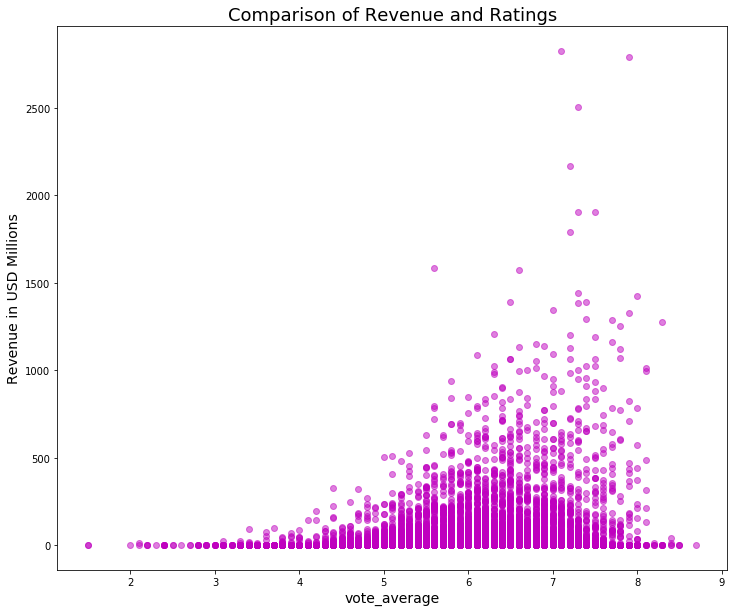

In [41]:
# I've actually decided to quickly mock up a scatterplot of ratings vs. revenue to see if initially these two dependent
# variables (for the purposes of this analysis) are themselves in any way related.

plt.figure(figsize=(12,10))
plt.scatter(df['vote_average'],df['revenue_Ms'], color='m', alpha = .5)

plt.title('Comparison of Revenue and Ratings', fontsize = 18)
plt.xlabel('vote_average', fontsize = 14)
plt.ylabel('Revenue in USD Millions', fontsize = 14);



This is quite interesting actually.  This scatterplot almost looks like the above histogram, noting a high concentration of points around the 6-7 mark.  However within that particular ratings band there is a decent range of revenue results.  Equally though, while sparse, there appear to be very few films breaking the £1Bn mark at or below that mode of 6.  Ratings between 7 and 8 look to have performed significantly better than the generally population, but the frequency is limited.

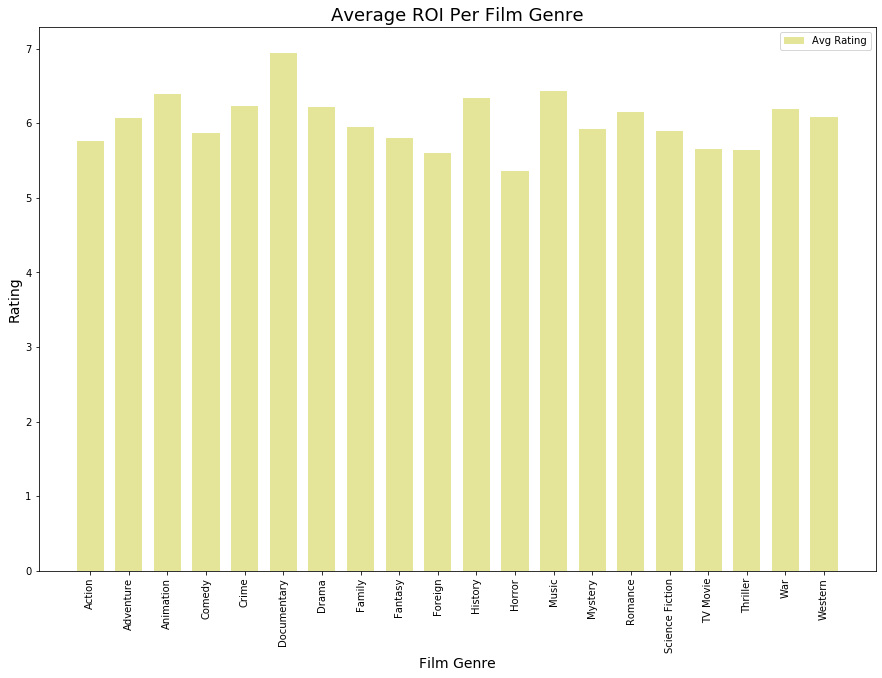

In [46]:
# Bar chart of average rating per Genre 

# create the new values per genre

average_rating = df.groupby('genres_1').mean()['vote_average']

#create a standar index, width and graph size

ind = np.arange(len(average_rating))
width = 0.70
plt.figure(figsize=(15,10))

#create the base bar graphs

ratings_bar = plt.bar(ind, average_rating, width, color = 'y', alpha = .4, label = 'Avg Rating')

#add, format and size the various labels

plt.ylabel('Rating', fontsize = 14)
plt.xlabel('Film Genre', fontsize = 14)
plt.title('Average Rating Per Film Genre', fontsize = 18)
labels = average_rating.index
plt.xticks(ind,labels, rotation = 90)

plt.legend();

In [74]:
# List of top ten studios by revenue to create a new data set with only these studios as Genre looks too consistent 
# to investigate further

# This then has generated a list of the top ten studios which we can use to filter down the main dataframe

df_studios = df.groupby('prod_co_1').sum().sort_values(by=['revenue_Ms'], ascending = False).head(10).index
df_studios

Index(['Paramount Pictures', 'Universal Pictures', 'Walt Disney Pictures',
       'Columbia Pictures', 'Twentieth Century Fox Film Corporation',
       'Warner Bros.', 'New Line Cinema', 'Lucasfilm',
       'Village Roadshow Pictures', 'DreamWorks SKG'],
      dtype='object', name='prod_co_1')

In [90]:
# use the df_studios list to generate a filtered dataframe and then groupby and get the ratings

df_studio_ratings = df.query('prod_co_1 in @df_studios').groupby('prod_co_1').mean()['vote_average']
df_studio_ratings

prod_co_1
Columbia Pictures                         6.023616
DreamWorks SKG                            6.273973
Lucasfilm                                 6.690000
New Line Cinema                           5.876214
Paramount Pictures                        6.142019
Twentieth Century Fox Film Corporation    6.072727
Universal Pictures                        6.071522
Village Roadshow Pictures                 6.027848
Walt Disney Pictures                      6.179812
Warner Bros.                              6.119186
Name: vote_average, dtype: float64

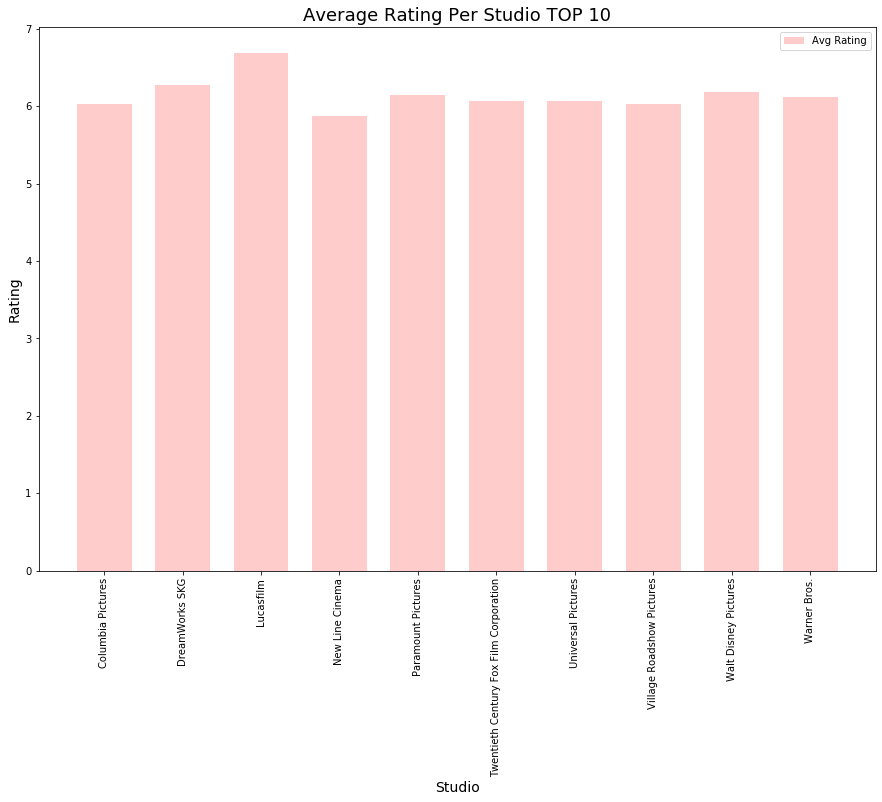

In [92]:
# Bar chart of average return per Genre along with average budget per Genre

#create a standar index, width and graph size

ind = np.arange(len(df_studio_ratings))
width = 0.70
plt.figure(figsize=(15,10))

#create the base bar graphs

studio_bar = plt.bar(ind, df_studio_ratings, width, color = 'r', alpha = .2, label = 'Avg Rating')

#add, format and size the various labels

plt.ylabel('Rating', fontsize = 14)
plt.xlabel('Studio', fontsize = 14)
plt.title('Average Rating Per Studio TOP 10', fontsize = 18)
labels = df_studio_ratings.index
plt.xticks(ind,labels, rotation = 90)

plt.legend();

It looks like regardless of studio or film genre the ratings tend to average out about the same, noting all cases land around 6, which is the same as the wider population and the histograme at the begining of the EDA process.  The key categorical variables dont look to be all that helpful at this stage.

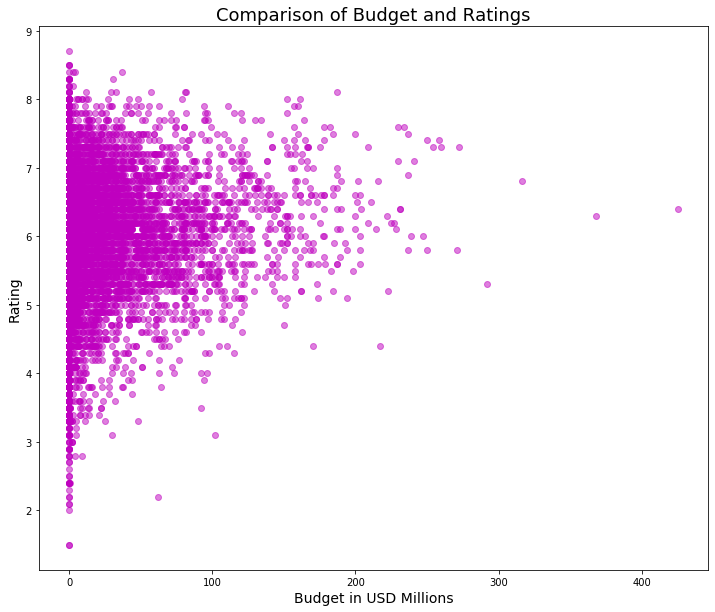

In [93]:
# Just a larger scatter plot looking at budget vs rating to investigate the trend a bit more


plt.figure(figsize=(12,10))
plt.scatter(df['budget_Ms'],df['vote_average'], color='m', alpha = .5)

plt.title('Comparison of Budget and Ratings', fontsize = 18)
plt.xlabel('Budget in USD Millions', fontsize = 14)
plt.ylabel('Rating', fontsize = 14);



This looks pretty hard to draw any conclustions from as it still looks like there is an even concentration around the 6-7 rating mark.

<a id='conclusions'></a>
## Conclusions

> Overall revenue seems easier to draw some conclusions from

>> 1. Generally spending more (bigger budget) does seem to suggest the films will generate more revenue however this is not statistically proven and does not mean causation
>> 2. However at a genre level things become more nuanced.  Revenue is not always higher for genres that spend more money and equally looking beyond just revenue to the ROI (measure of revenue after costs as a % of costs) shows even more subtlty in what higher or lower spending really means.
>> 3. Popularity equally did seem to align well with revenue, but agains some genres seems very unpredictable and some seemed to have a much stronger correlation.

> Ratings however seemed much harder to draw any meaningful insight from

>> 1. There didn't look to be much variation in either genre or film studio (noting I limited my review to only top 10 studios by all time gross revenues)
>> 2. There also didn't look to be much of a correlation between budget (spend) and overall ratings.  It sort of seems like broadly there is a nice bell curve of average ratings despite the amount you spend, the genre the film is in or the studio who made it.  I find that a bit hard to believe as there must be some concentration of either highly disliked or highly liked films.  If I had more time I think the ratings measure would need further evaluation
>> 3. There was however a bit of correlation between my two dependent variables (ratings and revenue) but the data points were pretty sparse, noting the limited number of mega blockbusters (by revenue) looked to be at the higher end (7 or 8 rating).  However weirdly the 9 rating generates almost no revenue, so again I'm concerned with the quality of the ratings scores.
